## YOLO, SSD

Face detection, 얼마나 작고 빨라질 수 있을까?

Dlib 라이브러리를 이용해서 Face Landmark를 찾아내는 것
- 충분하지 않다.
- 얼굴의 각도, 방향, 크기 등의 변화에 취약하고 잘 못 찾는다.

참고
- 카카오 얼굴인식 관련 리서치: https://tech.kakaoenterprise.com/63
- 네이버 얼굴검출 관련 오픈소스: https://github.com/clovaai/EXTD_Pytorch

그럼 어떻게 빠르게?
- Sliding window 를 버려야 빨라진다. 따라서 2-stage 방식의 detection 은 좋은 선택이 아니다.
- 연산의 병렬화를 해야 한다. TFLite 라는 도구를 이용하기도 하나.. 해결이 안될수도 있다.
- 무엇보다 적은 파라미터 수로도 정확한 성능을 가지는 모델을 설계하는 게 중요하다.

### Object Detection (1-Stage and 2-Stage)

- 2-Stage Detector
  - 정확도는 높지만 실행속도(FPS)가 느리다.
  - 물체가 존재하는 bounding box를 먼저 찾은(localization) 후 bounding box를 분류(classification) 하는 두 가지 과정을 순차적으로 거치기 때문이다.
- 1-Stage Detector
  - localization 과 classification 을 동시에 수행
  - 따라서 2-Stage Detector 보다는 빠르다.
  - 하지만 정확도가 낮다는 단점이 있다.

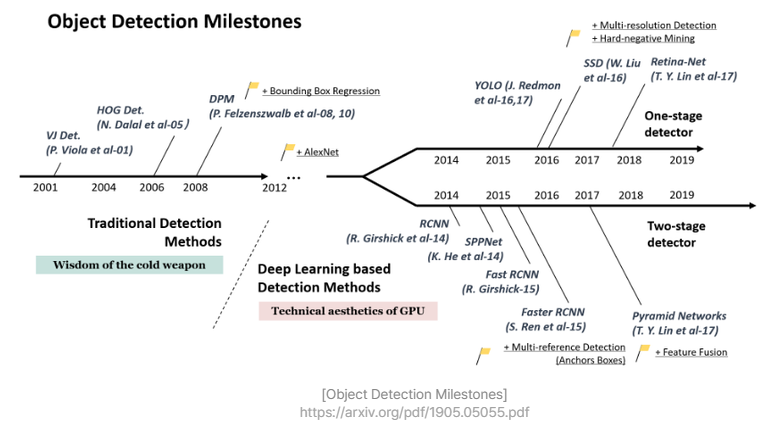

In [1]:
from IPython.display import Image
Image(filename='capture/object_detection_milestones.png') 

### YOLO

YOLO 논문의 1 저자이자 C로 구현된 오픈소스 뉴럴 네트워크 Darknet의 제작자인 Joseph Redmon

YOLO : "You Only Look Once: Unified, Real-Time Object Detection"  
https://youtu.be/NM6lrxy0bxs 참고

특징
- You Only Look Once
  - YOLO는 클래스에 대한 정보와 주변 정보까지 한번에 학습하고 처리한다. 따라서 배경 오류가 적고 일반화 성능이 좋다.
- Unified
  - Localization 과 Classification 을 동시에 수행
- Real-Time
  - 기본적인 YOLO 모델로는 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다.

참고
- RCNN 계열의 가정
  - "객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다." → Region Proposal Network(RPN)
- YOLO v1 의 가정
  - "이미지 내의 작은 영역을 나누면 그곳에 객체가 있을 수 있다." → grid 내에 객체가 존재한다.

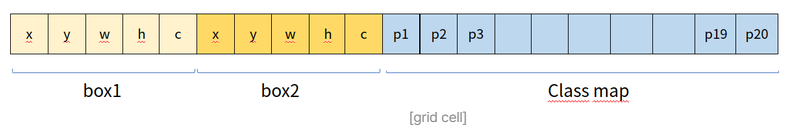

In [1]:
from IPython.display import Image
Image(filename='capture/yolo_grid_cell.png') 

논문에서는 입력 이미지를 7 x 7 grid 로 나누고, 각 grid cell 마다 예측하는 bound box(bbox)를 2개, 총 클래스의 수는 20으로 정하였다.  
그러면 하나의 grid cell 에 대해 위와 같은 tensor 가 나온다.

ex)  
Q> 1개의 7x7 grid 당 2개의 bounidng box(BBox) 와 20개 클래스를 예측하는 YOLO 를 만들고 싶은 경우, output tensor의 크기와 이를 flatten했을 때의 크기는?  
A> output tensor 는 7 x 7 x 30, 이를 flattern 하면 1470 이다.

NMS(None-Maximum Suppression) 알고리즘
- 객체를 포함하는 grid 가 많을 때 confidence score 순서대로 bbox 를 정렬
- 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거
- 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.
- 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환
- 각 클래스에 대해 위의 과정을 반복

#### YOLO v1

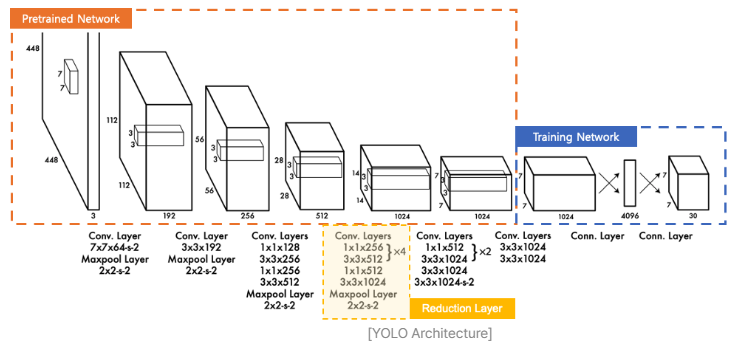

In [3]:
from IPython.display import Image
Image(filename='capture/yolo_v1.png') 

마지막 레이어는 Class 확률와 bbox 좌표를 학습하고 예측하여 S x S x (B * 5 + C) 크기의 텐서로 예측값이 출력됨.

한 이미지에서 예측한 클래스별 confidence score의 개수는 7 * 7 * 2 = 98개  
이 98개의 클래스별 confidence score 에 대해 20개의 class 를 기준으로 NMS 하여 object 에 대한 class 와 boudning box location 을 결정할 수 있음.

YOLO v1 의 loss
- 위치 예측과 관련된 localization loss 와 클래스 예측과 관련된 classification loss 가 있다.
- 두 loss 모두 SSE(sum-squared error)를 기반으로 함
  - SSE 는 이 두 loss 를 모두 동일하게 가중치를 줌 -> 모델의 불균형 초래 가능 -> λcoord 와 λ noobj 라는 두 개의 하이퍼파라미터를 사용
  - SSE 는 큰 box 든 작은 box 든 동일하게 가중치를 줌 -> 위치변화에 민감 -> bbox 의 너비와 높이에 square root 를 취해줌

YOLO v1 의 단점
- 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러 개의 객체를 예측하기 어려움
- 특히 새떼와 같이 그룹으로 나타나는 작은 object에 대해 예측을 제대로 하지 못함
- bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되기도 함
  - localization 이 다소 부정확
- loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미침

그래서 2017년에 YOLO v2 가 나오게 됨

#### YOLO v2

Joseph Redmon의 발표자료에서 intro에서 YOLO 자체로 좋긴 좋았는데 정확도가 아쉬웠다고 언급함

목적
- Make it better
- Do it faster 
- Make us stronger

recall을 올리고 localization을 잘 해보자!

1) Make it better
- Batch Normalization, High Resolution Classifier, Convolutional with Anchor boxes, Dimension Clusters, Direct location prediction, Fine-Grained Features, Multi-Scale Training 등의 방법을 사용

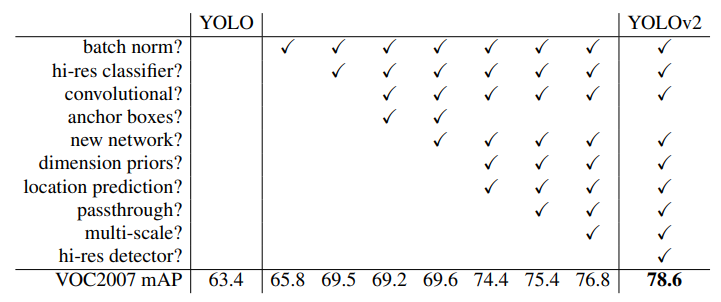

In [5]:
from IPython.display import Image
Image(filename='capture/yolo_v2_result_of_make_it_better.png') 

- Batch Normalization
  - 모든 conv 레이어에서 사용.
  - dropout 은 제거
- High Resolution Classifier
  - cjdmaqnxj 448x448 의 해상도로 학습
- Convolutional with Anchor boxes
  - bounding box를 예측하기 위해 YOLO v1의 Fully connected 레이어를 제거한 후 Fully Convolutional Network를 사용하였고, anchor box들을 사용해 bounding box를 예측
  - 또한 1개의 중앙점을 갖는 13 x 13 의 출력 feature map 을 만들기 위해 입력 이미지를 448 x 448 에서 416 x 416 로 줄임
- Dimension Clusters
  - Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정
  - YOLO v2는 k-means clustering을 적용해 최적의 anchor box를 결정
- Direct location prediction
  - 결정한 anchor box에 따라서 하나의 셀에서 5차원의 벡터로 이루어진 bounding box를 조정하여 예측
- Fine-Grained Features
  - 13 × 13의 feature map은 작은 물체 검출을 잘 하지 못한다는 단점이 있었기 때문에 YOLO v2는 passingthrough 레이어라는 것을 사용함
  - passingthrough 레이어는 이전 레이어의 26 × 26 feature map과 13 × 13의 feature map을 concatenate
  - 이렇게 하는 이유는 26 x 26의 feature map에 Fine-Grained Features(고해상도 피처)가 담겨 있기 때문
- Multi-Scale Training
  - 모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가면서 모델 학습
  - 모델이 32 간격으로 downsample 되므로 입력 이미지는 32의 배수가 될 수 있음 -> 그래서 입력 이미지의 크기는 {320, 352, ... 608} 중 하나가 사용됨

2) Do it faster

Deetection 속도를 향상시키기 위한 방법
- Darknet-19
  - 19개의 convolutional 레이어와 5개의 maxpooling 레이어 사용

3) Make us stronger

더 많은 범위의 class를 예측
- YOLO v2에서는 9천개의 클래스에서 detection할 수 있도록 하고, 그 모델을 YOLO9000 이라고 부름

YOLO v2의 성능 비교

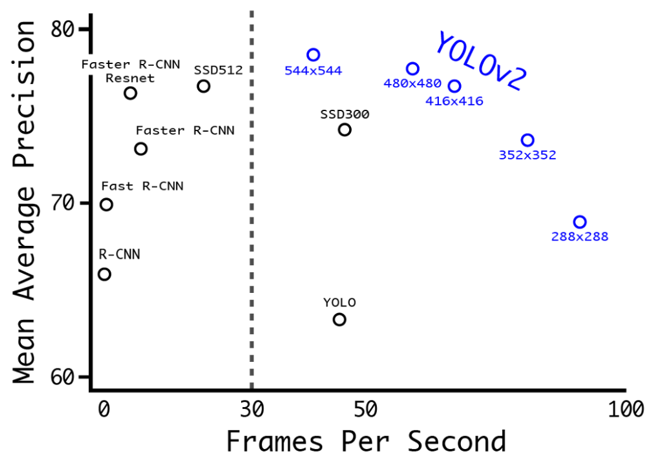

In [6]:
from IPython.display import Image
Image(filename='capture/yolo_v2_performance.png') 

#### YOLO v3

RetinaNet figure 에서 YOLO v2를 언급하면서 보통 figure에는 그려주지도 않는 신선함을 보여준다.

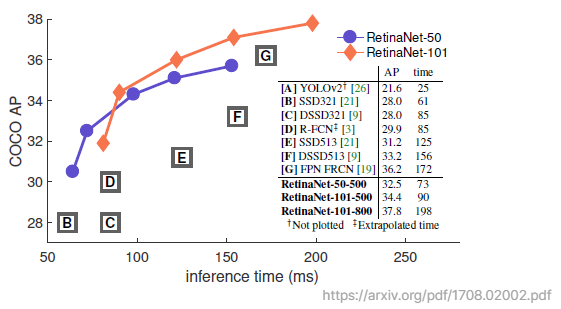

In [7]:
from IPython.display import Image
Image(filename='capture/RetinaNet_speed_versus_accuracy.png') 

YOLO v3는 YOLO v2보다는 속도는 조금 느리지만 정확도를 개선한 모델  
특히 YOLO의 약점이었던 작은 물체를 detection할 때 성능을 개선함.  
https://arxiv.org/abs/1804.02767 참고

YOLO v2 와의 차이점
- Bouding Box Prediction
  - 각각의 bounding box마다 objectness score, 즉 bounding box에 물체가 있는지를 예측하는 점수를 logistic regression을 사용해 예측
- Class prediction
  - YOLO v3는 하나의 이미지에 다양한 label을 붙일 수 있는 multilabel classification를 함 (ex: 여성의 이미지에 person 과 woman 이 label 을 붙일 수 있음)
  - 이를 위해 여러 개 중 하나만 찾는 softmax classifier가 아닌 해당 label이 맞는지 아닌지를 판단하는 logistic classifier를 사용함
  - binary cross entropy를 사용해 loss를 계산
- Predictions Across Scales
  - YOLO v3은 3개의 scale로 bouding box를 예측하였고, 각 scale당 3개의 bouding box를 예측
  - 따라서 총 9개의 bouding box가 나오게 되며, 텐서는 N × N × [3 ∗ (4 + 1 + 80)]
  - 여기서 3은 anchor box의 수이고, 4는 bounding box의 좌표, 너비, 높이이며, 1은 objectness score, 그리고 80의 클래스의 수
  - 또한 feature map을 2배씩 upsampling함(13, 26, 52)으로써 더 의미 있는 semantic information을 얻고, 이전 feature map과 concatenate하여 보다 fine-grained한 정보를 얻을 수 있었음
- DarkNet-53
  - 53개의 레이어를 사용

YOLO v3 구조

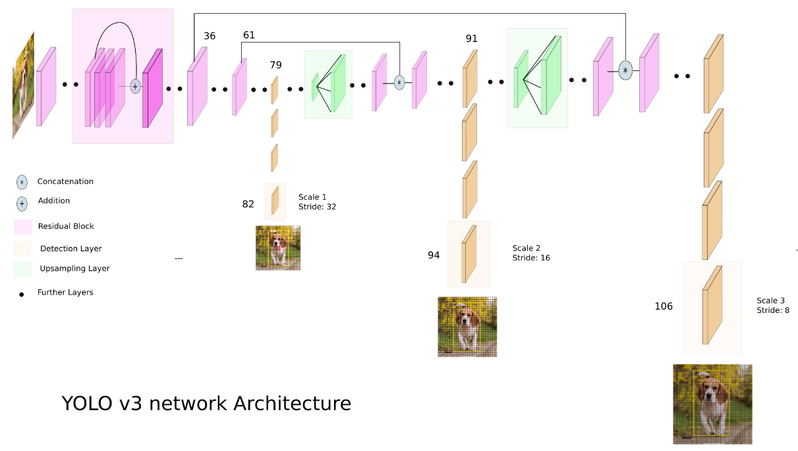

In [8]:
from IPython.display import Image
Image(filename='capture/yolo_v3_network_architecture.png') 

#### YOLO v3 그 이후

Redmon은 Computer Vision 연구가 자신의 목적과는 다르게 군사적으로 사용되고 있는 것에 큰 회의감을 느끼고 CV 연구를 그만두겠다고 선언함  
YOLO 등 DarkNet 프로젝트는 Alexey Bochkovskiy가 메인테이너로 이어 받게됨

YOLO v4
- YOLO v3+ CSPDarknet53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)

YOLO v5
- 2020년 6월에 YOLO v3을 PyTorch로 구현한 Glenn Jocher에 의해 발표
- YOLO v4의 백본과 유사하게 CSP-Darknet을 사용하고, YOLO v3과 동일하게 3가지 scale에서 bounding box를 각각 3개씩 찾음
- 자세한 설명은 https://ropiens.tistory.com/44 참고

PPYOLO
- PPYOLO는 2020년 8월에 바이두에서 발표된 모델로, PP라는 것은 바이두에서 만든 오픈 소스 딥러닝 전용 프레임워크 PaddlePaddle의 약자

Scaled YOLO v4
- 2020년 11월, YOLO v4에 scaling 기술을 적용한 Scaled YOLO v4가 공개됨
- https://arxiv.org/pdf/2011.08036.pdf 참고

PPYOLO v2
- 2021년 4월 PPYOLO의 업그레이드된 모델인 PPYOLO v2가 공개됨
- https://arxiv.org/pdf/2104.10419.pdf 참고

YOLOR
- 사람이 학습할 때 명시적 지식(explicit knowlege)과 암묵적 지식(implicit knowlege)를 사용한다는 것에서 착안하여 만들어진 모델
- https://arxiv.org/pdf/2105.04206.pdf 참고

YOLOX
- 2021년 8월에 나온 YOLOX: Exceeding YOLO Series in 2021는 Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등의 최신 연구를 적용하여 YOLO v3 SPP의 성능을 개선함
- Anchor-Free는 ground truth box 와 생성된 bounding box 안의 cell이 겹쳐 있으면 positive, 아니면 negative로 지정하여 detection을 수행함
- 이로 인해 연산량을 낮추고, 일반화를 시킬 수 있으며 class imbalance 문제도 해결하고, 정확도를 높일 수 있다고 함
- Anchor-Free 방식만으로는 Anchor 메커니즘의 정확도를 따라잡을 수 없었기 때문에 Multi-positives를 사용함
- Multi-positives는 각 객체의 중심과 주변에 해당하는 cell을 positive로 할당하여 예측을 하는 방법으로, 낮은 loss를 가진 k개의 cell만 학습에 참여시키는 simOTA과 함께 사용하여 정확도를 향상시킴
- https://arxiv.org/pdf/2107.08430.pdf 참고

YOLOS
- NLP 분야에서 큰 영향을 끼치고 있는 Transformer는 CV에서도 점차 영향력을 키우고 있음
- 이런 흐름에 맞춰 2021년 10월 You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection라는 논문에서 YOLOS라는 모델이 소개됨
- 즉 YOLOS는 Transformer Encoder와 NLP Heads만을 사용해 2D object detection을 수행한 모델
- https://arxiv.org/pdf/2106.00666.pdf 참고

### SSD

Single Shot MultiBox Detector

SSD는 YOLO v1에서 grid를 사용해서 생기는 단점을 해결할 수 있는 아래와 같은 몇 가지 테크닉을 제안함
- Pre-defined Anchor Box
- Image Pyramid

https://arxiv.org/pdf/1512.02325.pdf 참고

1) Pre-defined Anchor Box
- box 정보 (x, y, w, h)를 예측하기 위한 seed 정보가 없기 때문에 넓은 bbox 분포를 모두 학습할 수 없었다는 단점
- 따라서 Faster R-CNN 등에서 사용하는 anchor 를 적용할 필요가 있었음
- 이 anchor box를 SSD에서는 Default box라고 부름

2) Image Pyramid
- Image Pyramid는 ImageNet으로 사전학습된 VGG16을 사용
- VGG에서 pooling layer를 거친 block은 하나의 image feature로 사용 가능

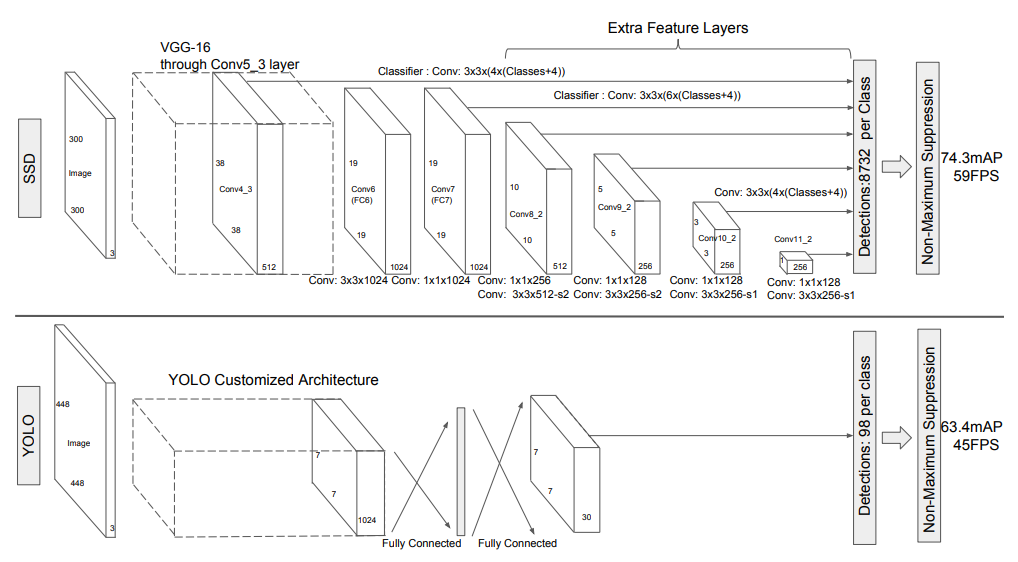

In [1]:
from IPython.display import Image
Image(filename='capture/ssd_versus_yolo.png') 

YOLO에서 7x7 크기의 feature map 하나만을 사용했다면, SSD는 38 x 38, 19 x 19, 10 x 10, 5 x 5, 3 x 3, 1 x 1인 다양한 크기의 feature map을 사용함.

즉 SSD는 서로 다른 크기의 feature map에서 object detection을 해서 작은 물체는 큰 feature map에서, 큰 물체는 작은 feature map에서 찾을 수 있게함.

#### SSD 의 framework

SSD는 입력 이미지와 각 객체에 대한 ground truth box만을 필요로 함.  
convolution을 할 때 비율이 다른 default box를 설정하는데, 아래의 그림은 다른 크기의 feature map에서, 각 객체마다 다른 비율의 default box를 4개씩 만들어 놓은 것을 표현한 것.

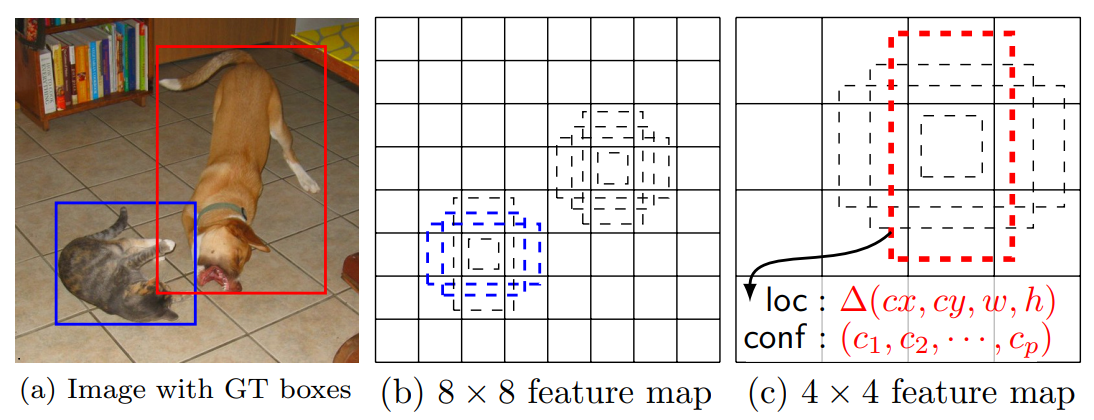

In [2]:
from IPython.display import Image
Image(filename='capture/ssd_framework.png')

#### Default box를 위한 scale

다양한 크기의 Default box 생성을 위한 과정
- feature map의 개수를 m, S_min 을 0.2, S_max 를 0.9 라고 할 때, 각 feature map당 서로 다른 6개의 s 값(scale 값) [0.2, 0.34, 0.48, 0.62, 0.76, 0.9] 이 나옴
- 이 값은 각 feature map에서 default box의 크기가 입력 이미지의 너비와 높이에 비해 얼마나 큰 지를 보여줌.
- 여기서 aspect ratio를 {1, 2, 3, 1/2, 1/3}로 설정하여 default box의 너비와 높이를 구할 수 있음.
- 예를 들어 k=3이라면 scale은 0.48이며 aspect ration가 2라면 너비는 0.68, 높이는 0.34
- 논문에서는 1개의 box를 더 추가해 총 6개의 default box의 너비와 높이 값을 구했음

#### SSD 의 loss 와 성능

학습 전에 ground truth와 defalt box의 jaccard overlap(IoU)이 0.5 이상인 것을 미리 매칭시켜 positive sample로 설정합니다.  
jaccard overlap이 0.5 이상인 default box를 모두 사용하면 학습 문제를 단순화시켜서 더 높은 성능을 가져올 수 있습니다.

SSD loss function
- Objective Loss Function
  - 전체 로스는 각 클래스 별로 예측한 값과 실제값 사이의 차이인 L_conf 와 bounding box regression 예측값과 실제값 사이의 차이인 L_loc 를 더한 값
- Localization Loss Function
  - 예측된 박스와 Ground truth box g, 파라미터 사이의 Smooth L1 loss, 즉 bounding box regression loss
- Confidence Loss Function
  - 여러 클래스의 confidence에 대한 softmax loss로, cross entropy loss와 비슷

Hard negative mining

- 대부분의 Default box가 배경
- 따라서 마지막 class의 loss 부분에서는 default box를 high confidence 순으로 정렬해 상위만 가져다 써서 positive:negative 비율을 1:3으로 정해 출력
- 이로써 최적화 속도가 빨라지고 안정적으로 학습 가능

SSD 의 성능

- SSD의 성능은 아래와 같이 Faster R-CNN보다는 성능이 조금 낮지만 속도는 빠르고, YOLO보다는 성능이 높고 속도는 느림
- SSD가 속도와 정확성을 동시에 잡자는 목표를 갖고 있었다는 것을 생각해보면, 그 목표를 이룬 것 같음

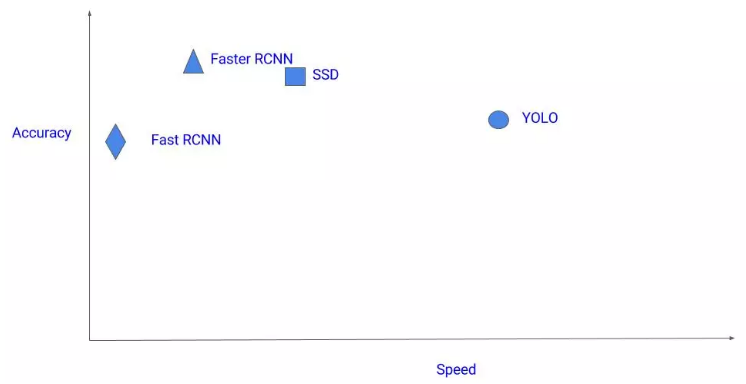

In [3]:
from IPython.display import Image
Image(filename='capture/ssd_performance.png')

### Face Detection을 위한 모델들

https://paperswithcode.com/task/face-detection 에서 다양한 모델 살펴볼 수 있음.

SOTA Face Detection 모델을 중심으로 간단히 살펴보자.

#### TinaFace

- TinaFace는 백본으로 ResNet50을 사용했고 기존에 존재했던 모듈(Feature Pyramid Network, Inception block, FCN 등)을 활용
- https://arxiv.org/pdf/2011.13183v3.pdf 참고

#### RetinaFace

- 1-Stage face detector로서, 다양한 얼굴 크기에 대해 pixel-wise face localization을 수행
- https://arxiv.org/pdf/1905.00641.pdf 참고

#### DSFD

- Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching (IAM)라는 기법을 사용해 성능을 높인 모델
- 언급한 세 기법이 two-stream으로 디자인되어 있어서 Dual Shot Face Detector라는 이름이 붙었다고 함
- https://arxiv.org/pdf/1810.10220.pdf 참고

#### S3FD

- 하나의 deep neural network를 사용해 다양한 얼굴 크기에 대해 face detection을 수행하며, 특히 작은 얼굴을 잘 찾는 모델
- 다양한 크기의 얼굴을 잘 찾기 위해 layer의 넓은 범위에 anchor를 바둑판 형식으로 배열하였고, anchor 크기도 새롭게 디자인
- https://arxiv.org/abs/1708.05237 참고